In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pprint
import logging

import numpy as np

import pymc3 as pm
import pymc3.theanof

import theano.tensor as tt

In [2]:
print(pm.__version__)

3.7


In [3]:
# as per pm.OrderedLogistic
class OrderedProbit(pm.Categorical):
    def __init__(self, mu, sigma, cutpoints, *args, **kwargs):

        mu = tt.as_tensor_variable(pymc3.theanof.floatX(mu))
        sigma = tt.as_tensor_variable(pymc3.theanof.floatX(sigma))
        cutpoints = tt.as_tensor_variable(cutpoints)

        p = (
            self.phi(x=cutpoints[:, 1:], mu=mu, sigma=sigma) -
            self.phi(x=cutpoints[:, :-1], mu=mu, sigma=sigma)
        )

        # must be >= 0
        p = tt.where(p <= 0, 1e-50, p)

        super().__init__(p=p, *args, **kwargs)

    @staticmethod
    def phi(x, mu, sigma):
        p = 0.5 * (1.0 + pm.math.erf(((x - mu) / sigma) / pm.math.sqrt(2)))
        return p

In [4]:
# can choose 1 to 10
response_options = np.arange(1, 11)

# evenly spaced cutpoints
cutpoints = np.concatenate(([-np.Inf], (response_options - 0.5)[1:], [+np.Inf]))[np.newaxis, :]
pprint.pprint(cutpoints)

array([[-inf,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,  inf]])


In [5]:
n_trials = 50

In [6]:
def get_model(y=None):
    
    with pm.Model() as model:
        
        mu = pm.Normal("mu", mu=np.mean(response_options), sigma=2.0)
        sigma = pm.Lognormal("sigma", mu=0.5, sigma=0.5)
        
        OrderedProbit("y", mu=mu, sigma=sigma, cutpoints=cutpoints, observed=y, shape=n_trials)
        
    return model

In [7]:
model = get_model()

In [8]:
with model:
    draw = pm.sample_prior_predictive(samples=1, random_seed=1234)

In [9]:
pprint.pprint(draw)

{'mu': array(6.44287033),
 'sigma': array(0.90892941),
 'sigma_log__': -0.0954878473532322,
 'y': array([5, 6, 6, 5, 5, 6, 7, 6, 5, 5, 6, 6, 5, 6, 5, 3, 6, 7, 5, 6, 4, 5,
       7, 6, 5, 6, 5, 6, 6, 5, 6, 4, 6, 6, 5, 7, 5, 7, 4, 5, 4, 6, 6, 6,
       4, 6, 5, 5, 4, 6])}


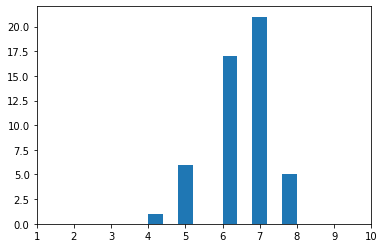

In [10]:
plt.hist(draw["y"] + 1);
plt.xlim([response_options[0], response_options[-1]]);

In [11]:
obs_model = get_model(y=draw["y"])

In [12]:
with obs_model:
    trace = pm.sample(cores=1, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 0, 0 divergences:   0%|          | 1/1000 [00:00<06:12,  2.69it/s]


ValueError: Mass matrix contains zeros on the diagonal. 
The derivative of RV `sigma_log__`.ravel()[0] is zero.
The derivative of RV `mu`.ravel()[0] is zero.

In [13]:
with obs_model:
    trace = pm.sample_smc()

Sample initial stage: ...
Stage:   0 Beta: 0.040 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.133 Steps:  25 Acce: 0.532
Stage:   2 Beta: 0.372 Steps:   6 Acce: 0.403
Stage:   3 Beta: 1.000 Steps:   8 Acce: 0.366


In [14]:
pm.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,6.448,0.131,6.207,6.695,0.004,0.003,1029.0,1029.0,1032.0,909.0,NaN
sigma,0.903,0.105,0.723,1.112,0.003,0.002,966.0,965.0,970.0,905.0,NaN


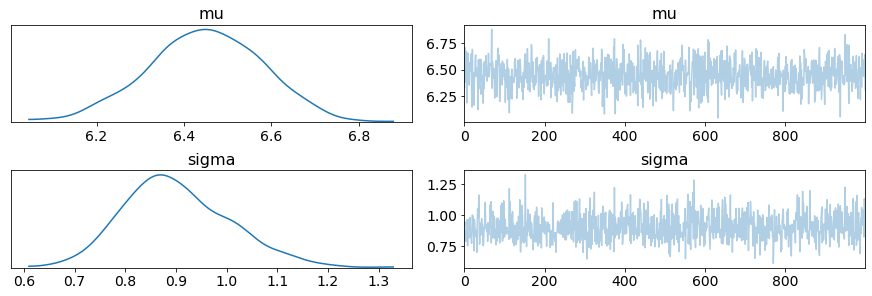

In [15]:
pm.traceplot(trace);

In [16]:
# run it a few times to check it wasn't just lucky
n_reps = 20

In [17]:
with model:
    draws = pm.sample_prior_predictive(samples=n_reps, random_seed=12345)

In [18]:
# temporarily turn off the output
logger = logging.getLogger("pymc3")
start_level = logger.level
logger.setLevel(logging.CRITICAL)

est_mus = np.full(n_reps, np.nan)
est_sigmas = np.full(n_reps, np.nan)

for i_rep in range(n_reps):
    
    obs_model = get_model(y=draws["y"][i_rep, :])
    
    with obs_model:
        trace = pm.sample_smc()
        
    est_mus[i_rep] = np.mean(trace["mu"])
    est_sigmas[i_rep] = np.mean(trace["sigma"])
    
logger.setLevel(start_level)

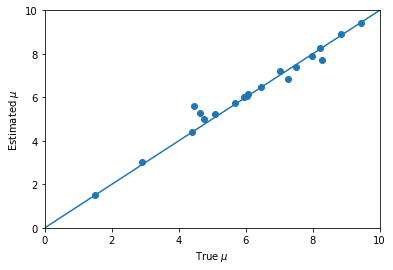

In [19]:
plt.scatter(draws["mu"], est_mus);
plt.xlim([0, 10]);
plt.ylim([0, 10]);
plt.plot([0, 10], [0, 10]);
plt.xlabel("True $\mu$");
plt.ylabel("Estimated $\mu$");

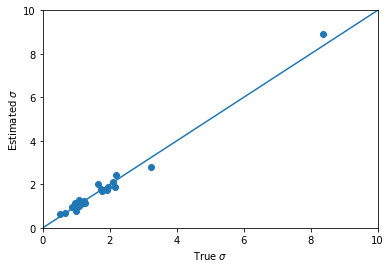

In [20]:
plt.scatter(draws["sigma"], est_sigmas);
plt.xlim([0, 10]);
plt.ylim([0, 10]);
plt.plot([0, 10], [0, 10]);
plt.xlabel("True $\sigma$");
plt.ylabel("Estimated $\sigma$");